# Ch4 exercises

## 1. What Linear Regression training algorithm can you use if you have a training set with millions of features?

If the whole training set fits in our memory we can use Batch, MB, and SGD. If not, we could use MB or SGD. Main disadvantage of SGD is training time as it goes thru every sample. With MB we go in small random batches.

## 2. Suppose the features in your training set have very different scales. What algorithms might suffer from this, and how? What can you do about it?

To fix this we should scale the data, for example using StdScaler from sklearn. Algorithms that suffer from this might be algorithms that use more than 2 features to train their models. We can name Polynomial Regression for example, or any other
algo. that uses more than 2 features. This affects the algorithm by creatin weird shapes on the hyperplane of error calculation. If scales are the same, then the minimun can be found easier.

## 3. Can Gradient Descent get stuck in a local minimum when training a Logistic Regression model?

Yes, as with any other model because of the nature of GD.

WRONG.

Logit. Regression cost function is convex, so it has no local minima to fail in.

## 4. Do all Gradient Descent algorithms lead to the same model provided you let them run long enough?

Apart from hyperparameters, all GD algorithms should lead to the same model which is finding the global minimun. The main problem is finding a local minimun and not being able to scape from it.
This depends on the learning rate mainly. A good learning rate will be able to scape from local minima and approach the global without any problem.

PARTLY WRONG.

SGD and MB will keep "jumping" around global minimun. We can stop this with a precission threshold.

## 5. Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?

If the validation set RMSE reaches a minimun and then goes up, while the test set RMSE is still going down, means that we are overfitting our model.

## 6. Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?

Not immediately. We can wait a certain amount of epochs just in case it starts going down again. We can set a certain amount of epochs to wait.

## 7. Which Gradient Descent algorithm (among those we discussed) will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?

The fastest one is Batch, as it takes into account the whole dataset. Batch will also converge, the others wont, but will stay near the global minimun.
To make then converge we can set a threshold difference on the error between previous epoch and the actual one. If the error is not changing, then we can finish.

WRONG.

SGD is the fastest because of its random nature.

## 8. Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?

This means that the model is overfitting, as it is training better much better on training than on validation. To fix this we can use more samples, maybe scale the data, and use less degrees on the model.

## 9. Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?

NO ANSWER.

If both errors are high, the model is probably underfitting. We can reduce alpha to smooth the model and reduce the bias.

## 10. Why would you want to use:

### a. Ridge Regression instead of plain Linear Regression (i.e., without any regularization)?

It is always preferable to have a bit a bit of regularization, just in case. Maybe on ideal data.

### b. Lasso instead of Ridge Regression?

If we are not certain of the weight of some features. Lasso can drop down weights on useless features.

### c. Elastic Net instead of Lasso?

Elastic Net is prefered because Lasso can fail when some features are strongly correlated.

## 11. Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?

We can directly use Softmax as it combines multiple binary classifiers.

WRONG.

Those two classes are not mutually excluyent. We should have two Logit. Regressors.


## 12. Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn).

In [15]:
import numpy as np

In [16]:
from sklearn.datasets import load_iris
iris = load_iris()

In [17]:
print(iris.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [18]:
print(iris["DESCR"])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [19]:
X = iris["data"]
y = iris["target"]

print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [24]:
print(X[:5, :])
print(y[:5])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
[0 0 0 0 0]


1. Prob function -> softmax
2. Loss function -> cross entropy
3. Batch gradient descent

In [147]:
def softmax(Z):
    exps = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def predict(W, X):
    Z = X.dot(W)
    A = softmax(Z)
    return np.argmax(A, 1)

def one_hot_encode(y, num_classes):
    num_samples = len(y)
    one_hot = np.zeros((num_samples, num_classes))
    one_hot[np.arange(num_samples), y] = 1
    return one_hot

def calc_learning_rate(starting_learning_rate, epoch, decay_rate):
    return 1 / (1 + decay_rate * epoch) * starting_learning_rate

def train(X, y, num_epochs=100000, learning_rate = 0.01, early_stop_wait=1000):
    epsilon = 1e-15
    losses = []
    epochs_since_min = 0
    min_loss = np.inf

    num_samples, num_features = X.shape
    print(f"Number of samples: {num_samples}")
    print(f"Number of features: {num_features}")

    num_classes = len(np.unique(y))
    print(f"Number of classes: {num_classes}")

    W = np.random.rand(num_features, num_classes)
    print(f"Shape of W: {W.shape}")

    for epoch in range(num_epochs):
        Z = X.dot(W)
        A = softmax(Z)
        y_ohe = one_hot_encode(y, num_classes)

        cross_entropy = -np.sum(y_ohe * np.log(A + epsilon))
        mean_cross_entropy = cross_entropy / num_samples
        losses.append(mean_cross_entropy)
        W = W - learning_rate * (1/num_samples) * X.T.dot(A - y_ohe)

        if (epoch % (num_epochs//10) == 0):
            print(f"Epoch {epoch} Loss: {mean_cross_entropy}")

        if (mean_cross_entropy < min_loss):
            epochs_since_min = 0
            min_loss = mean_cross_entropy
        else:
            epochs_since_min += 1
        
        if (epochs_since_min >= early_stop_wait):
            print(f"Stopping early at epoch {epoch}")
            break

    return W, losses
            
w, losses = train(X, y)


Number of samples: 150
Number of features: 4
Number of classes: 3
Shape of W: (4, 3)
Epoch 0 Loss: 3.1279817221590003
Epoch 10000 Loss: 0.13374191817120273
Epoch 20000 Loss: 0.10488159057324092
Epoch 30000 Loss: 0.09391657285439003
Epoch 40000 Loss: 0.08811886834199029
Epoch 50000 Loss: 0.08454495834190932
Epoch 60000 Loss: 0.0821344420579146
Epoch 70000 Loss: 0.0804088067548269
Epoch 80000 Loss: 0.0791197749635325
Epoch 90000 Loss: 0.07812557013069876


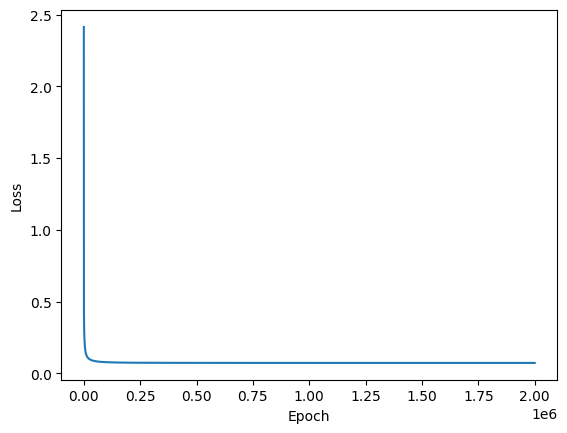

In [144]:
# Plot loss

import matplotlib.pyplot as plt

def plot_loss(losses_arr):
    '''
    It only takes an array of loss values. Plot with axis loss and epoch
    '''
    plt.plot(losses_arr)
    # Print the loss value at the last epoch with an arrow pointing to it. Text to the left of the arrow
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

plot_loss(losses)